In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from gtfparse import read_gtf
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
import matplotlib.lines as mlines
import bioframe
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

## DEGs

In [4]:
# Read GTF with gene annotation
genes = read_gtf('../gencode.vM25.annotation.gtf')
genes = genes[genes['feature'] == 'gene']
genes = genes[['seqname', 'start', 'end', 'strand', 'gene_id', 'gene_type', 'gene_name']]
genes.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


,seqname,start,end,strand,gene_id,gene_type,gene_name
0,chr1,3073253,3074322,+,ENSMUSG00000102693.1,TEC,4933401J01Rik
3,chr1,3102016,3102125,+,ENSMUSG00000064842.1,snRNA,Gm26206
6,chr1,3205901,3671498,-,ENSMUSG00000051951.5,protein_coding,Xkr4
24,chr1,3252757,3253236,+,ENSMUSG00000102851.1,processed_pseudogene,Gm18956
27,chr1,3365731,3368549,-,ENSMUSG00000103377.1,TEC,Gm37180


#### Not expressed genes

In [5]:
degs_2H = pd.read_csv('./degs/degs_2H_DESeq.csv', sep = '\s+', header = 0)
degs_2H['gene_id'] = degs_2H.index

non_expressed = genes.merge(degs_2H, on = 'gene_id', how = 'left', suffixes = ('', '_deg'))
non_expressed = non_expressed[non_expressed['baseMean'].isna()]
columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type']
non_expressed = non_expressed[columns_to_save]

print(len(non_expressed))
non_expressed.to_csv('./degs/not_expressed.bed', header = 1, index = 0, sep = '\t')

35989


#### 2H vs DMSO

In [6]:
degs_2H = pd.read_csv('./degs/degs_2H_DESeq.csv', sep = '\s+', header = 0)
degs_2H['gene_id'] = degs_2H.index
degs_2H.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000051951.5,9.602379,0.460083,1.011305,0.454940,0.649152,0.970364,ENSMUSG00000051951.5
ENSMUSG00000103922.1,7.709780,-0.247778,1.130278,-0.219218,0.826480,NaN,ENSMUSG00000103922.1
ENSMUSG00000033845.13,786.398976,-0.156457,0.154803,-1.010689,0.312165,0.856111,ENSMUSG00000033845.13
ENSMUSG00000102275.1,69.512054,-0.235029,0.381559,-0.615972,0.537913,0.955592,ENSMUSG00000102275.1
ENSMUSG00000025903.14,1784.197805,0.134916,0.140630,0.959371,0.337372,0.876149,ENSMUSG00000025903.14


In [7]:
degs_2H = degs_2H.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_2H = degs_2H[columns_to_save]

degs_2H.sort_values('padj').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
9280,chr8,105860580,105879330,Nutf2,ENSMUSG00000008450.8,+,protein_coding,-2.266090,1295.045265,1.141424e-59,2.129783e-55
529,chr1,87945119,88008551,Usp40,ENSMUSG00000005501.14,-,protein_coding,-5.203364,168.435577,5.435943e-53,5.071463e-49
12893,chr11,116030322,116061214,Unk,ENSMUSG00000020770.13,+,protein_coding,-2.734409,504.278376,9.668789e-51,6.013665e-47
5745,chr5,130029290,130060789,Crcp,ENSMUSG00000025532.13,+,protein_coding,-2.997654,337.268696,1.169132e-47,5.453707e-44
4347,chr4,132308623,132311024,Snhg12,ENSMUSG00000086290.9,+,lincRNA,-2.127957,1695.868996,1.386488e-46,5.174095e-43


In [8]:
degs_2H_up = degs_2H[(degs_2H['padj'] < 0.05) & (degs_2H['log2FoldChange'] > 0.5)]
degs_2H_down = degs_2H[(degs_2H['padj'] < 0.05) & (degs_2H['log2FoldChange'] < -0.5)]
degs_2H_stable = degs_2H[~degs_2H['gene_id'].isin([x for x in degs_2H['gene_id'].values \
                                                   if x in degs_2H_down['gene_id'].values or x in degs_2H_up['gene_id'].values])]

print('Up-regulated:', len(degs_2H_up))
print('Down-regulated:', len(degs_2H_down))
print('No change:', len(degs_2H_stable))
print('Low expression:', len(genes) - len(degs_2H))

Up-regulated: 102
Down-regulated: 617
No change: 18693
Low expression: 35989


In [15]:
degs_2H_down.to_csv('./degs/degs_2H_down.bed', header = 1, index = 0, sep = '\t')
degs_2H_up.to_csv('./degs/degs_2H_up.bed', header = 1, index = 0, sep = '\t')
degs_2H_stable.to_csv('./degs/degs_2H_stable.bed', header = 1, index = 0, sep = '\t')
degs_2H[['gene_name', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_2H.ranked.rnk', sep = '\t', header = 0, index = 0)
degs_2H[['gene_id', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_2H.ranked.ensid.rnk', sep = '\t', header = 0, index = 0)

#### 6H vs DMSO

In [9]:
degs_6H = pd.read_csv('./degs/degs_6H_DESeq.csv', sep = '\s+', header = 0)
degs_6H['gene_id'] = degs_6H.index
degs_6H.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000051951.5,9.602379,-0.460968,1.056660,-0.436250,0.662655,NaN,ENSMUSG00000051951.5
ENSMUSG00000103922.1,7.709780,0.034132,1.126076,0.030310,0.975820,NaN,ENSMUSG00000103922.1
ENSMUSG00000033845.13,786.398976,-0.233555,0.155532,-1.501650,0.133188,0.459394,ENSMUSG00000033845.13
ENSMUSG00000102275.1,69.512054,0.000800,0.380811,0.002102,0.998323,0.999372,ENSMUSG00000102275.1
ENSMUSG00000025903.14,1784.197805,0.144014,0.140838,1.022550,0.306521,0.676847,ENSMUSG00000025903.14


In [10]:
degs_6H = degs_6H.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_6H = degs_6H[columns_to_save]

degs_6H.sort_values('padj').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
4347,chr4,132308623,132311024,Snhg12,ENSMUSG00000086290.9,+,lincRNA,-2.511260,1695.868996,6.334255e-63,1.086515e-58
9280,chr8,105860580,105879330,Nutf2,ENSMUSG00000008450.8,+,protein_coding,-2.320851,1295.045265,9.408307e-62,8.069034e-58
11202,chr10,80901203,80918245,Lmnb2,ENSMUSG00000062075.13,-,protein_coding,-3.663321,280.094605,4.067838e-55,2.325854e-51
529,chr1,87945119,88008551,Usp40,ENSMUSG00000005501.14,-,protein_coding,-5.675130,168.435577,9.474282e-50,4.062809e-46
2946,chr3,88081971,88121048,Iqgap3,ENSMUSG00000028068.14,+,protein_coding,-2.766693,433.857863,1.914492e-47,6.567856e-44


In [11]:
degs_6H_up = degs_6H[(degs_6H['padj'] < 0.05) & (degs_6H['log2FoldChange'] > 0.5)]
degs_6H_down = degs_6H[(degs_6H['padj'] < 0.05) & (degs_6H['log2FoldChange'] < -0.5)]
degs_6H_stable = degs_6H[~degs_6H['gene_id'].isin([x for x in degs_6H['gene_id'].values \
                                                   if x in degs_6H_down['gene_id'].values or x in degs_6H_up['gene_id'].values])]

print('Up-regulated:', len(degs_6H_up))
print('Down-regulated:', len(degs_6H_down))
print('No change:', len(degs_6H_stable))
print('Low expression:', len(genes) - len(degs_6H))

Up-regulated: 293
Down-regulated: 825
No change: 18294
Low expression: 35989


In [16]:
degs_6H_down.to_csv('./degs/degs_6H_down.bed', header = 1, index = 0, sep = '\t')
degs_6H_up.to_csv('./degs/degs_6H_up.bed', header = 1, index = 0, sep = '\t')
degs_6H_stable.to_csv('./degs/degs_6H_stable.bed', header = 1, index = 0, sep = '\t')
degs_6H[['gene_name', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_6H.ranked.rnk', sep = '\t', header = 0, index = 0)
degs_6H[['gene_id', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_6H.ranked.ensid.rnk', sep = '\t', header = 0, index = 0)

#### 24H vs DMSO

In [12]:
degs_24H = pd.read_csv('./degs/degs_24H_DESeq.csv', sep = '\s+', header = 0)
degs_24H['gene_id'] = degs_24H.index
degs_24H.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000051951.5,9.602379,0.605147,1.016135,0.595538,0.551484,NaN,ENSMUSG00000051951.5
ENSMUSG00000103922.1,7.709780,0.731270,1.104257,0.662228,0.507825,NaN,ENSMUSG00000103922.1
ENSMUSG00000033845.13,786.398976,-0.213877,0.155872,-1.372137,0.170021,0.458661,ENSMUSG00000033845.13
ENSMUSG00000102275.1,69.512054,-0.111563,0.384115,-0.290441,0.771479,0.920693,ENSMUSG00000102275.1
ENSMUSG00000025903.14,1784.197805,-0.261886,0.141668,-1.848585,0.064518,0.259199,ENSMUSG00000025903.14


In [13]:
degs_24H = degs_24H.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_24H = degs_24H[columns_to_save]

degs_24H.sort_values('padj').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
9280,chr8,105860580,105879330,Nutf2,ENSMUSG00000008450.8,+,protein_coding,-2.543760,1295.045265,2.621991e-72,4.398915e-68
16450,chr16,35397312,35490873,Pdia5,ENSMUSG00000022844.8,-,protein_coding,-2.790663,1170.738100,1.194056e-71,1.001634e-67
11202,chr10,80901203,80918245,Lmnb2,ENSMUSG00000062075.13,-,protein_coding,-3.753223,280.094605,1.021213e-55,5.710964e-52
7997,chr7,101663633,101795506,Clpb,ENSMUSG00000001829.17,+,protein_coding,-2.218078,1502.514167,9.290149e-54,3.896521e-50
2946,chr3,88081971,88121048,Iqgap3,ENSMUSG00000028068.14,+,protein_coding,-2.893420,433.857863,2.213322e-50,7.426580e-47


In [14]:
degs_24H_up = degs_24H[(degs_24H['padj'] < 0.05) & (degs_24H['log2FoldChange'] > 0.5)]
degs_24H_down = degs_24H[(degs_24H['padj'] < 0.05) & (degs_24H['log2FoldChange'] < -0.5)]
degs_24H_stable = degs_24H[~degs_24H['gene_id'].isin([x for x in degs_24H['gene_id'].values \
                                                      if x in degs_24H_down['gene_id'].values or x in degs_24H_up['gene_id'].values])]

print('Up-regulated:', len(degs_24H_up))
print('Down-regulated:', len(degs_24H_down))
print('No change:', len(degs_24H_stable))
print('No expression:', len(genes) - len(degs_24H))

Up-regulated: 693
Down-regulated: 1052
No change: 17667
No expression: 35989


In [18]:
degs_24H_down.to_csv('./degs/degs_24H_down.bed', header = 1, index = 0, sep = '\t')
degs_24H_up.to_csv('./degs/degs_24H_up.bed', header = 1, index = 0, sep = '\t')
degs_24H_stable.to_csv('./degs/degs_24H_stable.bed', header = 1, index = 0, sep = '\t')
degs_24H[['gene_name', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_24H.ranked.rnk', sep = '\t', header = 0, index = 0)
degs_24H[['gene_id', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_24H.ranked.ensid.rnk', sep = '\t', header = 0, index = 0)

## Volcano plots

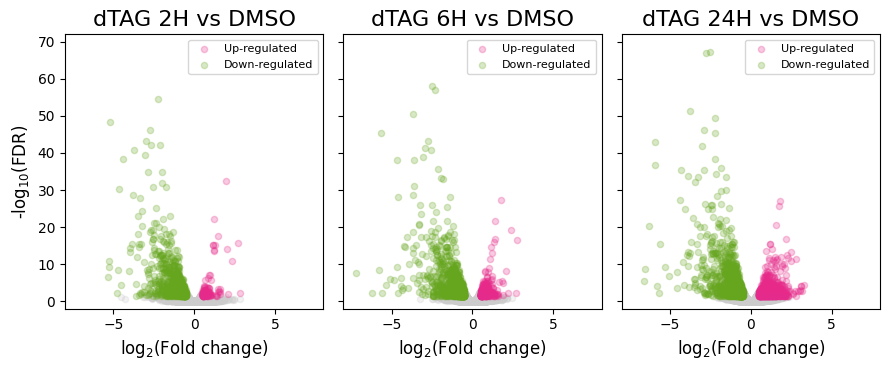

In [19]:
plt.figure(figsize = (9, 3.8))

plt.subplot(131)
plt.title('dTAG 2H vs DMSO', fontsize = 16)
plt.scatter(degs_2H_stable['log2FoldChange'], -np.log10(degs_2H_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_2H_up['log2FoldChange'], -np.log10(degs_2H_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(degs_2H_down['log2FoldChange'], -np.log10(degs_2H_down['padj']), 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.ylabel('-log$_{10}$(FDR)', fontsize = 12)
plt.xlim((-8, 8))
plt.ylim((-2, 72))
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(132)
plt.title('dTAG 6H vs DMSO', fontsize = 16)
plt.scatter(degs_6H_stable['log2FoldChange'], -np.log10(degs_6H_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_6H_up['log2FoldChange'], -np.log10(degs_6H_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(degs_6H_down['log2FoldChange'], -np.log10(degs_6H_down['padj']), 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.xlim((-8, 8))
plt.ylim((-2, 72))
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70], [])
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(133)
plt.title('dTAG 24H vs DMSO', fontsize = 16)
plt.scatter(degs_24H_stable['log2FoldChange'], -np.log10(degs_24H_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_24H_up['log2FoldChange'], -np.log10(degs_24H_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(degs_24H_down['log2FoldChange'], -np.log10(degs_24H_down['padj']), 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.xlim((-8, 8))
plt.ylim((-2, 72))
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70], [])
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.show()

## MA plots

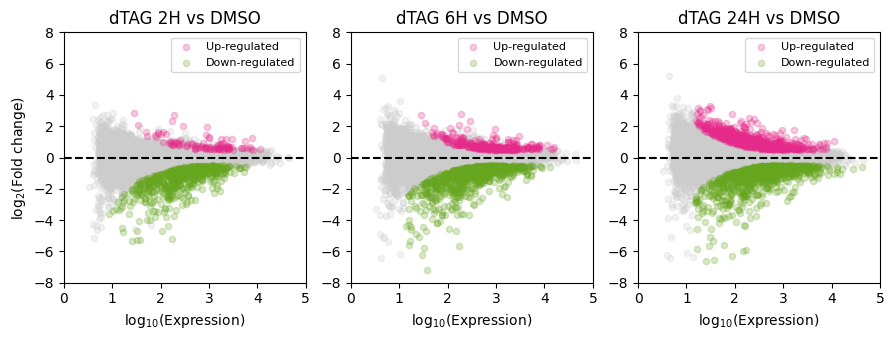

In [20]:
plt.figure(figsize = (9, 3.5))

plt.subplot(131)
plt.title('dTAG 2H vs DMSO', fontsize = 12)
plt.scatter(np.log10(degs_2H_stable['baseMean']), degs_2H_stable['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(degs_2H_up['baseMean']), degs_2H_up['log2FoldChange'], 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(np.log10(degs_2H_down['baseMean']), degs_2H_down['log2FoldChange'], 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylabel('log$_2$(Fold change)', fontsize = 10)
plt.ylim((-8, 8))
plt.xlim((0, 5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(132)
plt.title('dTAG 6H vs DMSO', fontsize = 12)
plt.scatter(np.log10(degs_6H_stable['baseMean']), degs_6H_stable['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(degs_6H_up['baseMean']), degs_6H_up['log2FoldChange'], 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(np.log10(degs_6H_down['baseMean']), degs_6H_down['log2FoldChange'], 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylim((-8, 8))
plt.xlim((0, 5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(133)
plt.title('dTAG 24H vs DMSO', fontsize = 12)
plt.scatter(np.log10(degs_24H_stable['baseMean']), degs_24H_stable['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(degs_24H_up['baseMean']), degs_24H_up['log2FoldChange'], 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(np.log10(degs_24H_down['baseMean']), degs_24H_down['log2FoldChange'], 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylim((-8, 8))
plt.xlim((0, 5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.show()

## Sankey plot

In [97]:
degs_sankey = list(degs_2H_up['gene_id'].values) + list(degs_2H_down['gene_id'].values) + list(degs_6H_up['gene_id'].values) + list(degs_6H_down['gene_id'].values) + list(degs_24H_up['gene_id'].values) + list(degs_24H_down['gene_id'].values)
degs_sankey = np.unique(degs_sankey)
degs_sankey_ids = [x.split('.')[0].split('ENSMUSG')[-1].lstrip('0') for x in degs_sankey]

time_2H = ['2H']*len(degs_sankey)
category_2H = []
for deg in degs_sankey:
    if deg in degs_2H_up['gene_id'].values:
        category_2H.append('Up')
    elif deg in degs_2H_down['gene_id'].values:
        category_2H.append('Down')
    else:
        category_2H.append('n.s.')
        
time_6H = ['6H']*len(degs_sankey)
category_6H = []
for deg in degs_sankey:
    if deg in degs_6H_up['gene_id'].values:
        category_6H.append('Up')
    elif deg in degs_6H_down['gene_id'].values:
        category_6H.append('Down')
    else:
        category_6H.append('n.s.')

time_24H = ['8H']*len(degs_sankey)
category_24H = []
for deg in degs_sankey:
    if deg in degs_24H_up['gene_id'].values:
        category_24H.append('Up')
    elif deg in degs_24H_down['gene_id'].values:
        category_24H.append('Down')
    else:
        category_24H.append('n.s.')
        
        
degs_sankey_df = pd.DataFrame({'Timepoint': time_2H+time_6H+time_24H, 'id': degs_sankey_ids+degs_sankey_ids+degs_sankey_ids, 'cat': category_2H+category_6H+category_24H})
degs_sankey_df.to_csv('/DATA/users/magnitov/znf143/ttseq/degs/df_for_sankey.tsv', header = 1, index = 0, sep = '\t')

## Overlap with ZFP143 targets

In [32]:
zfp143_targets = pd.read_csv('../chipseq/annotations/ZFP143_target_genes.ensembl_id.txt', header = None)
zfp143_targets = [x.split('.')[0] for x in zfp143_targets[0].values]

degs_2H_down = pd.read_csv('./degs/degs_2H_down.bed', sep = '\t')
degs_6H_down = pd.read_csv('./degs/degs_6H_down.bed', sep = '\t')
degs_24H_down = pd.read_csv('./degs/degs_24H_down.bed', sep = '\t')

degs_2H_up = pd.read_csv('./degs/degs_2H_up.bed', sep = '\t')
degs_6H_up = pd.read_csv('./degs/degs_6H_up.bed', sep = '\t')
degs_24H_up = pd.read_csv('./degs/degs_24H_up.bed', sep = '\t')

degs_2H_stable = pd.read_csv('./degs/degs_2H_stable.bed', sep = '\t')
degs_6H_stable = pd.read_csv('./degs/degs_6H_stable.bed', sep = '\t')
degs_24H_stable = pd.read_csv('./degs/degs_24H_stable.bed', sep = '\t')

In [33]:
fractions_targets, numbers_targets = [], []
for gene_set in [degs_2H_down, degs_6H_down, degs_24H_down, 
                 degs_2H_up, degs_6H_up, degs_24H_up,
                 degs_2H_stable, degs_6H_stable, degs_24H_stable]:
    number_of_targets = len([x for x in gene_set['gene_id'].values if x.split('.')[0] in zfp143_targets])
    numbers_targets.append(number_of_targets)
    fractions_targets.append(round(number_of_targets / len(gene_set), 4))

In [34]:
print('2H DOWN: %s out of %s (%s perc)' % (numbers_targets[0], len(degs_2H_down), fractions_targets[0]*100))
print('6H DOWN: %s out of %s (%s perc)' % (numbers_targets[1], len(degs_6H_down), fractions_targets[1]*100))
print('24H DOWN: %s out of %s (%s perc)' % (numbers_targets[2], len(degs_24H_down), fractions_targets[2]*100))
print()
print('2H UP: %s out of %s (%s perc)' % (numbers_targets[3], len(degs_2H_up), fractions_targets[3]*100))
print('6H UP: %s out of %s (%s perc)' % (numbers_targets[4], len(degs_6H_up), fractions_targets[4]*100))
print('24H UP: %s out of %s (%s perc)' % (numbers_targets[5], len(degs_24H_up), fractions_targets[5]*100))
print()
print('2H STABLE: %s out of %s (%s perc)' % (numbers_targets[6], len(degs_2H_stable), fractions_targets[6]*100))
print('6H STABLE: %s out of %s (%s perc)' % (numbers_targets[7], len(degs_6H_stable), fractions_targets[7]*100))
print('24H STABLE: %s out of %s (%s perc)' % (numbers_targets[8], len(degs_24H_stable), fractions_targets[8]*100))

2H DOWN: 527 out of 617 (85.41 perc)
6H DOWN: 568 out of 825 (68.85 perc)
24H DOWN: 630 out of 1052 (59.89 perc)

2H UP: 39 out of 102 (38.24 perc)
6H UP: 43 out of 293 (14.680000000000001 perc)
24H UP: 44 out of 693 (6.35 perc)

2H STABLE: 1660 out of 18693 (8.88 perc)
6H STABLE: 1615 out of 18294 (8.83 perc)
24H STABLE: 1552 out of 17667 (8.780000000000001 perc)


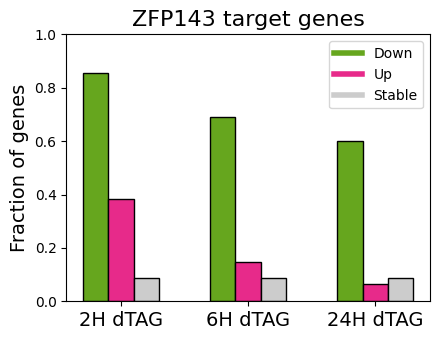

In [37]:
plt.figure(figsize = (4.5, 3.5))
plt.title('ZFP143 target genes', fontsize = 16)
plt.bar(list(np.arange(0, 6, 2)-0.4) + list(np.arange(0, 6, 2)) + list(np.arange(0, 6, 2)+0.4), fractions_targets, 
        width = 0.4, edgecolor = 'k', color = ['#66A61E', '#66A61E', '#66A61E', '#E72A8A', '#E72A8A', '#E72A8A', '#CCCCCC', '#CCCCCC', '#CCCCCC'])
plt.xticks([0, 2, 4], ['2H dTAG', '6H dTAG', '24H dTAG'], fontsize = 14)
plt.ylabel('Fraction of genes', fontsize = 14)
plt.ylim((0, 1))

custom_lines = [Line2D([0], [0], color='#66A61E', lw=4),
                Line2D([0], [0], color='#E72A8A', lw=4),
                Line2D([0], [0], color='#CCCCCC', lw=4)]
plt.legend(custom_lines, ['Down', 'Up', 'Stable'])

plt.tight_layout()
plt.show()

## Mitochondrial genes

In [21]:
chrM_2H = degs_2H[(degs_2H['seqname'] == 'chrM') & (degs_2H['gene_type'].isin(['protein_coding', 'Mt_rRNA']))][['gene_name', 'baseMean', 'log2FoldChange', 'padj']]
chrM_6H = degs_6H[(degs_6H['seqname'] == 'chrM') & (degs_6H['gene_type'].isin(['protein_coding', 'Mt_rRNA']))][['gene_name', 'baseMean', 'log2FoldChange', 'padj']]
chrM_24H = degs_24H[(degs_24H['seqname'] == 'chrM') & (degs_24H['gene_type'].isin(['protein_coding', 'Mt_rRNA']))][['gene_name', 'baseMean', 'log2FoldChange', 'padj']]

chrM_degs = chrM_2H.merge(chrM_6H, on = 'gene_name').merge(chrM_24H, on = 'gene_name')
chrM_degs.columns = ['gene_name', 'baseMean_2H', 'log2FC_2H', 'FDR_2H', 
                                  'baseMean_6H', 'log2FC_6H', 'FDR_6H', 
                                  'baseMean_24H', 'log2FC_24H', 'FDR_24H']
chrM_degs

,gene_name,baseMean_2H,log2FC_2H,FDR_2H,baseMean_6H,log2FC_6H,FDR_6H,baseMean_24H,log2FC_24H,FDR_24H
0,mt-Rnr1,28179.686327,0.023961,0.992467,28179.686327,0.263349,0.175164,28179.686327,-0.724034,4.769845e-08
1,mt-Rnr2,42554.988702,0.033004,0.988599,42554.988702,0.243128,0.260690,42554.988702,-0.603203,3.208873e-05
2,mt-Nd1,16205.464968,-0.044706,0.983962,16205.464968,0.117736,0.751170,16205.464968,-0.754709,2.514202e-06
3,mt-Nd2,12776.615090,0.011464,0.998445,12776.615090,0.225308,0.456294,12776.615090,-0.716802,5.167351e-05
4,mt-Co1,13029.695757,-0.159372,0.780753,13029.695757,0.014163,0.982616,13029.695757,-0.910609,2.877344e-10
5,mt-Nd4,6012.427752,-0.108039,0.927939,6012.427752,0.055475,0.911299,6012.427752,-0.966156,1.612323e-09
6,mt-Nd5,15109.740777,-0.123129,0.852160,15109.740777,0.042413,0.922028,15109.740777,-1.078652,1.106457e-16
7,mt-Nd6,4528.313292,-0.070830,0.968792,4528.313292,0.164017,0.636866,4528.313292,-0.571529,1.984169e-03
8,mt-Cytb,11336.979834,-0.108973,0.897731,11336.979834,0.062186,0.877592,11336.979834,-1.053480,2.451240e-15


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


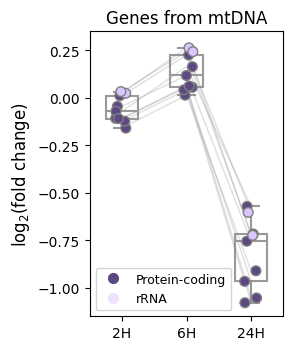

In [22]:
plt.figure(figsize = (2.5, 3.7))
plt.title('Genes from mtDNA')

sns.stripplot(data = [chrM_degs['log2FC_2H'].values[2:], chrM_degs['log2FC_6H'].values[2:], chrM_degs['log2FC_24H'].values[2:]],
              palette = ['#5D4884'], edgecolor = 'grey', linewidth = 1, s = 7, label = 'Protein-coding')
sns.stripplot(data = [chrM_degs['log2FC_2H'].values[:2], chrM_degs['log2FC_6H'].values[:2], chrM_degs['log2FC_24H'].values[:2]],
              palette = ['#D9C5FF'], edgecolor = 'grey', linewidth = 1, s = 7, label = 'rRNA')
sns.boxplot(data = [chrM_degs['log2FC_2H'].values, chrM_degs['log2FC_6H'].values, chrM_degs['log2FC_24H'].values],
              palette = ['w'], width = 0.5)
for expr in chrM_degs[['log2FC_2H', 'log2FC_6H', 'log2FC_24H']].values:
    plt.plot([0, 1, 2], expr, color = 'grey', lw = 1, alpha = 0.25)

plt.xticks([0, 1, 2], ['2H', '6H', '24H'])
plt.yticks(fontsize = 10)
plt.ylabel('log$_2$(fold change)', fontsize = 12)
plt.xlim((-0.5, 2.5))
plt.ylim((-1.15, 0.35))
plt.yticks([-1, -0.75, -0.5, -0.25, 0, 0.25])

line1 = mlines.Line2D([], [], color='#5D4884', marker='o', linewidth=0,
                          markersize = 7, label = 'Protein-coding')
line2 = mlines.Line2D([], [], color='#ECE2FF', marker='o', linewidth=0,
                          markersize = 7, label = 'rRNA')
plt.legend(handles=[line1, line2], loc = 'lower left', fontsize = 9)
plt.show()

## MitoCarta annotation

In [25]:
zfp143_targets = list(pd.read_csv('../chipseq/annotations/ZFP143_peaks_GENCODE_genes_associations.txt', sep = '\t')['gene_name'].values)

degs_2h_down = pd.read_csv('./degs/degs_2H_down.bed', sep = '\t')
degs_6h_down = pd.read_csv('./degs/degs_6H_down.bed', sep = '\t')
degs_24h_down = pd.read_csv('./degs/degs_24H_down.bed', sep = '\t')
degs_2h_down = list(degs_2h_down['gene_name'].values)
degs_6h_down = list(degs_6h_down['gene_name'].values)
degs_24h_down = list(degs_24h_down['gene_name'].values)
degs_down = np.unique([degs_2h_down+degs_6h_down+degs_24h_down])

mitocarta = pd.read_excel('../Mouse.MitoCarta3.0.xls', sheet_name = 'C MitoPathways')
mitocarta.head()

,MitoPathway,MitoPathway Hierarchy,Genes
0,Mitochondrial central dogma,Mitochondrial central dogma,"2810006K23Rik, Aars2, Alkbh1, Angel2, Apex1, A..."
1,mtDNA maintenance,Mitochondrial central dogma > mtDNA maintenance,"Apex1, Atad3a, Dna2, Endog, Exog, Lig3, Mettl4..."
2,mtDNA replication,Mitochondrial central dogma > mtDNA maintenanc...,"Dna2, Exog, Lig3, Mgme1, Polg, Polg2, Polrmt, ..."
3,mtDNA nucleoid,Mitochondrial central dogma > mtDNA maintenanc...,"Atad3a, Mterf1a, Mterf1b, Mterf2, Poldip2, Pol..."
4,mtDNA repair,Mitochondrial central dogma > mtDNA maintenanc...,"Apex1, Exog, Lig3, Ogg1, Polb, Polg, Primpol, ..."


In [26]:
number_of_genes_in_pathway, number_of_genes_in_pathway_zfp143_targets, number_of_genes_in_pathway_zfp143_targets_down = [], [], [] 
names_genes_in_pathway_zfp143_targets, names_genes_in_pathway_zfp143_targets_down = [], []
for pathway in mitocarta.values:
    pathway_genes = pathway[2].split(', ')
    pathway_genes_zfp143_targets = [x for x in pathway_genes if x in zfp143_targets]
    pathway_genes_zfp143_targets_down = [x for x in pathway_genes if x in zfp143_targets and x in degs_down]
    
    number_of_genes_in_pathway.append(len(pathway_genes))
    number_of_genes_in_pathway_zfp143_targets.append(len(pathway_genes_zfp143_targets))
    number_of_genes_in_pathway_zfp143_targets_down.append(len(pathway_genes_zfp143_targets_down))
    names_genes_in_pathway_zfp143_targets.append(', '.join(pathway_genes_zfp143_targets))
    names_genes_in_pathway_zfp143_targets_down.append(', '.join(pathway_genes_zfp143_targets_down))
    
mitocarta['Genes ZFP143 targets'] = names_genes_in_pathway_zfp143_targets
mitocarta['Genes ZFP143 targets down'] = names_genes_in_pathway_zfp143_targets_down
mitocarta['N_total'] = number_of_genes_in_pathway
mitocarta['N_targets'] = number_of_genes_in_pathway_zfp143_targets
mitocarta['N_targets_down'] = number_of_genes_in_pathway_zfp143_targets_down
mitocarta.to_csv('./annotations/ZFP143_target_genes.MitoCarta_overlap.tsv', sep = '\t', header = 1, index = 0)

In [30]:
mitocarta = pd.read_csv('./annotations/ZFP143_target_genes.MitoCarta_overlap.tsv', sep = '\t')
mitocarta = mitocarta[['MitoPathway', 'MitoPathway Hierarchy', 'Genes', 'Genes ZFP143 targets',
                       'Genes ZFP143 targets down', 'N_total', 'N_targets', 'N_targets_down']]
mitocarta.head(10)

,MitoPathway,MitoPathway Hierarchy,Genes,Genes ZFP143 targets,Genes ZFP143 targets down,N_total,N_targets,N_targets_down
0,Mitochondrial central dogma,Mitochondrial central dogma,"2810006K23Rik, Aars2, Alkbh1, Angel2, Apex1, A...","Angel2, Chchd1, Coa3, Cox14, Dap3, Dars2, Dhx3...","Coa3, Eral1, Fastk, Fastkd1, Gatb, Mpv17l2, Mr...",230,59,25
1,mtDNA maintenance,Mitochondrial central dogma > mtDNA maintenance,"Apex1, Atad3a, Dna2, Endog, Exog, Lig3, Mettl4...","Exog, Mgme1, Mutyh, Poldip2, Polrmt, Primpol, ...","Poldip2, Tfam",31,8,2
2,mtDNA replication,Mitochondrial central dogma > mtDNA maintenanc...,"Dna2, Exog, Lig3, Mgme1, Polg, Polg2, Polrmt, ...","Exog, Mgme1, Polrmt, Tfam, Top3a",Tfam,14,5,1
3,mtDNA nucleoid,Mitochondrial central dogma > mtDNA maintenanc...,"Atad3a, Mterf1a, Mterf1b, Mterf2, Poldip2, Pol...","Poldip2, Polrmt, Tfam","Poldip2, Tfam",11,3,2
4,mtDNA repair,Mitochondrial central dogma > mtDNA maintenanc...,"Apex1, Exog, Lig3, Ogg1, Polb, Polg, Primpol, ...","Exog, Primpol",NaN,9,2,0
5,mtDNA modifications,Mitochondrial central dogma > mtDNA maintenanc...,Mettl4,NaN,NaN,1,0,0
6,mtDNA stability and decay,Mitochondrial central dogma > mtDNA maintenanc...,"Endog, Exog, Mgme1","Exog, Mgme1",NaN,3,2,0
7,mtRNA metabolism,Mitochondrial central dogma > mtRNA metabolism,"Alkbh1, Angel2, Cdk5rap1, Ddx28, Dhx30, Dus2, ...","Angel2, Dhx30, Elac2, Eral1, Fastk, Fastkd1, L...","Eral1, Fastk, Fastkd1, Rexo2, Tfam",76,14,5
8,Transcription,Mitochondrial central dogma > mtRNA metabolism...,"Mrpl12, Mterf1a, Mterf1b, Mtres1, Polrmt, Tefm...","Polrmt, Tfam",Tfam,9,2,1
9,mtRNA granules,Mitochondrial central dogma > mtRNA metabolism...,"Alkbh1, Ddx28, Dhx30, Eral1, Fastk, Fastkd1, F...","Dhx30, Eral1, Fastk, Fastkd1, Noa1, Prorp, Ptc...","Eral1, Fastk, Fastkd1",28,8,3


In [31]:
mitocarta[mitocarta['MitoPathway Hierarchy'].isin([x for x in mitocarta['MitoPathway Hierarchy'] if len(x.split('>')) == 1])].sort_values('N_targets', ascending = 0)[['MitoPathway', 'N_total', 'N_targets', 'N_targets_down']]

,MitoPathway,N_total,N_targets,N_targets_down
0,Mitochondrial central dogma,230,59,25
54,Metabolism,464,50,22
34,OXPHOS,168,42,19
138,Mitochondrial dynamics and surveillance,102,20,8
21,"Protein import, sorting and homeostasis",88,19,11
126,Small molecule transport,85,8,5
130,Signaling,47,7,3
